## Детекция объектов

Реализация самописного детектора и использование готового решения.

Датасет с игральными картами, содержащий около 300 картинок, данные хранятся в xml в формате PascalVOC. Задача поиска и выделения на фотографиях нескольких типов карт.

#### Подготовка данных

In [ ]:
# !wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip

# !unzip -q data.zip

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
# функция, чтобы по названию картинки подтягивать аннотации
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # xmin ymin xmax ymax, class in dict
        bndbox = member.find("bndbox")

        class_name = member.find("name").text
        class_int = class_dict[class_name] # название класса в int

        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        res = [xmin, ymin, xmax, ymax, class_int]

        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx): # метод будет использован для формирования батчей для обучения
        fname = self.filenames[idx]
        image = np.array(Image.open(fname))
        _, bboxes = self.__get_raw_item__(idx)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):  # метод будет использован для формирования батчей для обучения
        return len(self.filenames)

Определение стандартных нормализаций и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

#### Функция для визуализации данных: принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях

* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html)

In [ ]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    category2color = {0: "red",
                      1: "blue",
                      2: "green",
                      3: "brown",
                      4: "olive",
                      5: "purple"}

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    ) # добавление нескольких изображений на одну pyplot figure

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        # permute для правильного отображения каналов в matplotlib
        images[i] = images[i].permute(1, 2, 0)
        # откат нормализации (обратное преобразование)
        images[i] = images[i] * torch.tensor(std).view(1, 1, -1) + torch.tensor(mean).view(1, 1, -1)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        ax.imshow(images[i]) # отображение графиков

        for bbox in bboxes[i]:

          xmin, ymin, xmax, ymax, class_int = bbox
          ax.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                  fill=False, ec=category2color[class_int])) # отрисовка прямоугольников

          # int класса в строку с названием при помощи class_dict_inv
          ax.text(xmin, ymin-20, train_ds.class_dict_inv[class_int],
                  color=category2color[class_int], size=12, bbox=dict(facecolor='white', alpha=0.8, linestyle='')) # добавление текста с аннотацией

    fig.tight_layout()
    plt.show()

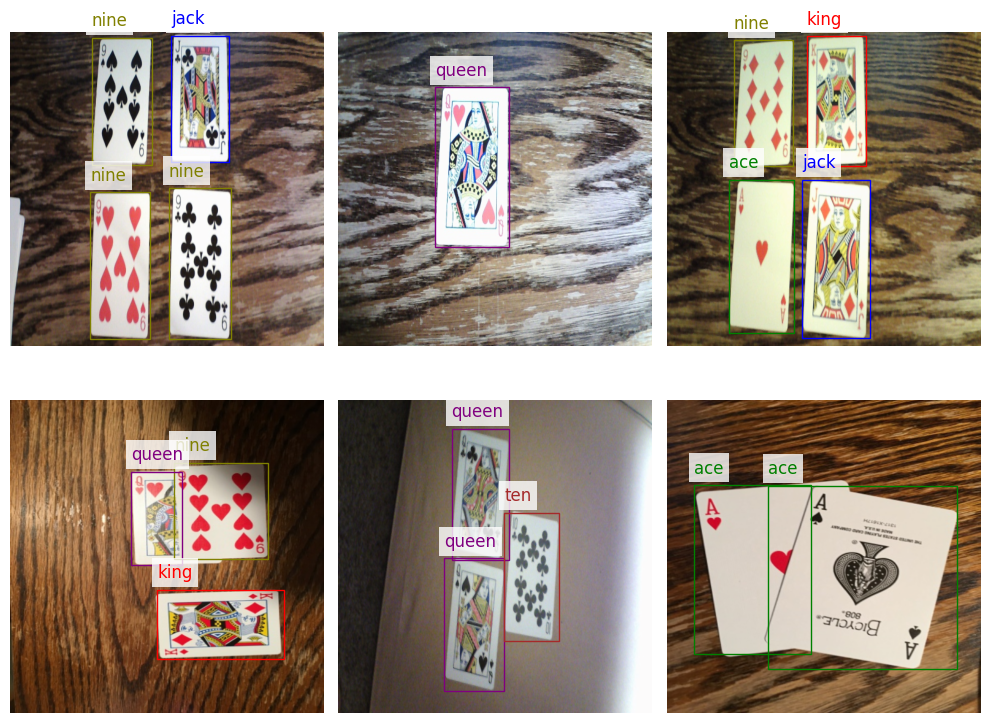

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

#### Реализация YOLO-like детектора

[You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640).

ResNet для извлечения признаков, на выходе - карта признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

**Реализация функции, которая позволит кастомизировать, как именно батч конструируется из примеров ([pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn))**

Функция принимает на вход лист прямоугольников и генерирует тензор размера Bx16x16x6. Первая размерность - количество примеров в батче. Далее идут две пространственные размерности (сетка 16x16). В каналах записаны:
* Сдвиги центра bbox относительно начала клеточки ("пикселя" на изображении 16x16 на выходе сети). Сдвиги записываются в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сети в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        x_cell = w / 16 # (или просто downsample) # размер клетки по X в пикс
        y_cell = h / 16 # размер клетки по Y в пикс
        w_box = (xmax - xmin) / w # ширина бокса отнормированная (деление на ширину исходного изображения)
        h_box = (ymax - ymin) / h # высота бокса отнормированная (деление на высоту исходного изображения)

        # подсчет координат центра и сдвигов
        cx = (xmax + xmin) / 2 # координаты центра в исходных координатах
        cy = (ymax + ymin) / 2
        cx_idx = (cx // x_cell).to(int) # подсчет индекса центра на карте признаков размера 16x16 (координаты пикселя, куда запишутся параметры коробки)
        cy_idx = (cy // y_cell).to(int)

        # подсчет сдвигов относительно cx_idx
        cx_box = (cx - cx_idx * x_cell) / x_cell # (сначала нашла сдвиг в исходных координатах, потом отнормировала)
        cy_box = (cy - cy_idx * y_cell) / y_cell

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Как выглядит решетка размера 16x16 на исходном изображении:

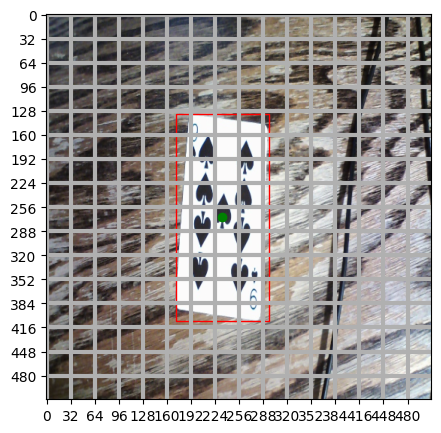

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

**Реализация функции для обратного преобразования, декодирования выхода сети**

Функция применяется к выходу сети и выводит набор прямоугольников с корректными размерами и координатами, а также классами.

Выход сети больше, чем Bx16x16x6, потому что в задаче классов больше одного: у каждой клеточки из этих 16*16 будет свой вектор длины C, который будем использовать для определения класса.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    bboxes = []
    for obj_idx in range(b):

      bboxes_per_obj = []
      for i in range(w):

        for j in range(h):

          x0, y0 = i * upsample, j * upsample # координаты левого верхнего угла клетки (относительно которого посчитаны сдвиги) в исходных координатах, т.е. cx_idx в исходных координатах
          cx_box = pred[obj_idx, 0, j, i].item() # отнормированные сдвиги
          cy_box = pred[obj_idx, 1, j, i].item()
          cx, cy = x0 + cx_box * upsample, y0 + cy_box * upsample # координаты центра прямоугольника в исходных координатах

          w_box = pred[obj_idx, 2, j, i].item() # отнормированные ширина и высота
          h_box = pred[obj_idx, 3, j, i].item()
          w_box = w_box * img_w # ширина и высота в исходных координатах
          h_box = h_box * img_h

          xmax, xmin = cx + w_box / 2, cx - w_box / 2
          ymax, ymin = cy + h_box / 2, cy - h_box / 2

          # classes идут в конце
          # проверяю число каналов пришедшего объекта, если оно 6, то это target и надо брать значение, которое записано в клеточке
          if c == 6:  # если target, беру класс
            class_int = pred[obj_idx, 5, j, i].item()
          # иначе (каналов больше 6) - это выход нейронки, и надо брать самый вероятный из них
          else: # если prediction, беру argmax последних каналов, отвечающих за вероятности принадлежности каждому классу, для определения класса
            class_int = torch.argmax(pred[obj_idx, 5:, j, i]).item()

          conf = pred[obj_idx, 4, j, i].item()
          if conf >= threshold:
            bboxes_per_obj.append([xmin, ymin, xmax, ymax, class_int])

      bboxes.append(bboxes_per_obj)

    return bboxes

**Реализация модели**

In [ ]:
C = len(train_ds.class_dict) # количество классов в датасете


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        # сначала применяются первые 4 блока (до layer4 включительно) ResNet50
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        model = nn.Sequential(*list(model.children())[:-2])

        # далее добавляются несколько блоков (Conv2D, BatchNorm2D, ReLU) с постепенным уменьшением количества каналов до 5+C, а размера изображения до 16x16
        new_layers = nn.Sequential(nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=(3, 3), padding=1),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU(),

                                   nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(3, 3), padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),

                                   nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),

                                   nn.Conv2d(in_channels=32, out_channels=5+C, kernel_size=(3, 3), padding=1),
                                   nn.BatchNorm2d(5+C),
                                   nn.ReLU(),

                                   # последний слой - свертка
                                   nn.Conv2d(in_channels=5+C, out_channels=5+C, kernel_size=(3, 3), padding=1),
                                   # т.к. все значения, которые предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками),
                                   # после финальной свертки применим сигмоиду; для классов в такой постановке это не навредит
                                   nn.Sigmoid())

        self.model = nn.Sequential(model, new_layers)

    def forward(self, img):
        pred = self.model(img)

        return pred

**Реализация функции потерь**

* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей:
    - localization loss - MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - бинарная кросс-энтропия факта наличия объекта для всех пикселей: отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1, поскольку их гораздо больше)

In [ ]:
def special_loss(pred, target, check=False, C=C):
    # параметр C используется для задачи числа классов, от него зависит индексация
    mask = target[:, 4, :, :] > 0 # маска, которая говорит о положении детектируемых объектов

    mse_loss = nn.MSELoss(reduction='sum')
    bse_loss = nn.BCELoss(reduction='sum') # бинарная кросс-энтропия
    cross_entropy_loss = nn.CrossEntropyLoss(reduction='sum')

    # localization loss
    cx_box_pred, cx_box_target = torch.masked_select(pred[:, 0, :, :], mask), torch.masked_select(target[:, 0, :, :], mask)
    cy_box_pred, cy_box_target = torch.masked_select(pred[:, 1, :, :], mask), torch.masked_select(target[:, 1, :, :], mask)

    localization_loss = mse_loss(cx_box_pred, cx_box_target) + mse_loss(cy_box_pred, cy_box_target)

    # box loss
    w_box_pred, w_box_target = torch.masked_select(pred[:, 2, :, :], mask), torch.masked_select(target[:, 2, :, :], mask)
    h_box_pred, h_box_target = torch.masked_select(pred[:, 3, :, :], mask), torch.masked_select(target[:, 3, :, :], mask)

    box_loss = mse_loss(torch.sqrt(w_box_pred), torch.sqrt(w_box_target)) + mse_loss(torch.sqrt(h_box_pred), torch.sqrt(h_box_target))

    # classification loss
    classes_pred = [] # список, в который буду добавлять вероятности классов по каналам
    classes_target = torch.masked_select(target[:, 5, :, :], mask)

    if check:
      for ch in range(3):
       class_pred = torch.masked_select(pred[:, 5 + ch, :, :], mask)
       classes_pred.append(class_pred)

    else:
      for ch in range(C):
       class_pred = torch.masked_select(pred[:, 5 + ch, :, :], mask)
       classes_pred.append(class_pred)

    classes_pred = torch.stack(classes_pred, dim=1)
    classification_loss = cross_entropy_loss(classes_pred, classes_target.long())

    # confidence loss
    # уверенности для недетектируемых объектов
    conf_pred_0, conf_target_0 = torch.masked_select(pred[:, 4, :, :], ~mask), torch.masked_select(target[:, 4, :, :], ~mask)
    # уверенности для детектируемых объектов
    conf_pred_1, conf_target_1 = torch.masked_select(pred[:, 4, :, :], mask), torch.masked_select(target[:, 4, :, :], mask)

    confidence_loss = bse_loss(conf_pred_1, conf_target_1) + 0.1 * bse_loss(conf_pred_0, conf_target_0)

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=6) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

#### Обучение модели (реализация цикла обучения)

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        images, targets = batch["image"].to(device), batch["target"].to(device)
        predictions = model(images)
        loss = special_loss(predictions, targets)
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 135.032;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 71.998;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 54.067;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 45.662;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 39.514;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 35.692;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 33.384;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 32.231;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 31.321;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 30.123;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 30.942;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 29.032;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 28.085;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 26.734;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 25.698;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# делаем предсказание и перекладываем результат на cpu
model.eval()
with torch.no_grad():
  predict = model(batch["image"].to(device)).to("cpu")

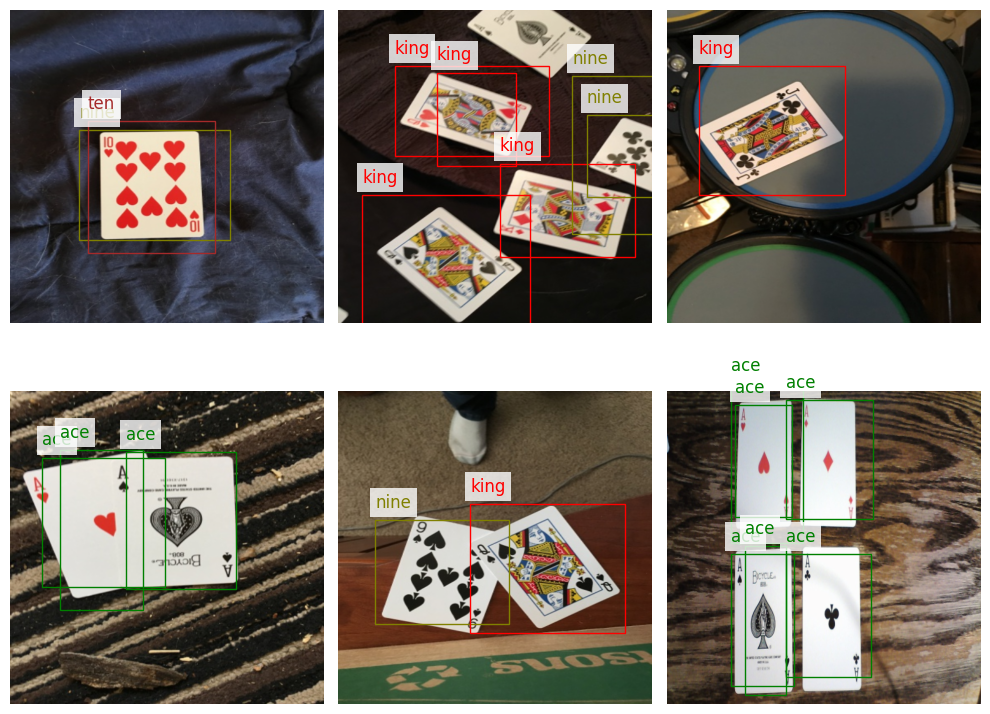

In [ ]:
# сделаем визуализацию предсказаний
decoded_predict = decode_prediction(predict, threshold=0.1)
out = [test_ds[i] for i in range(6)]
visualize([o["image"] for o in out], decoded_predict)

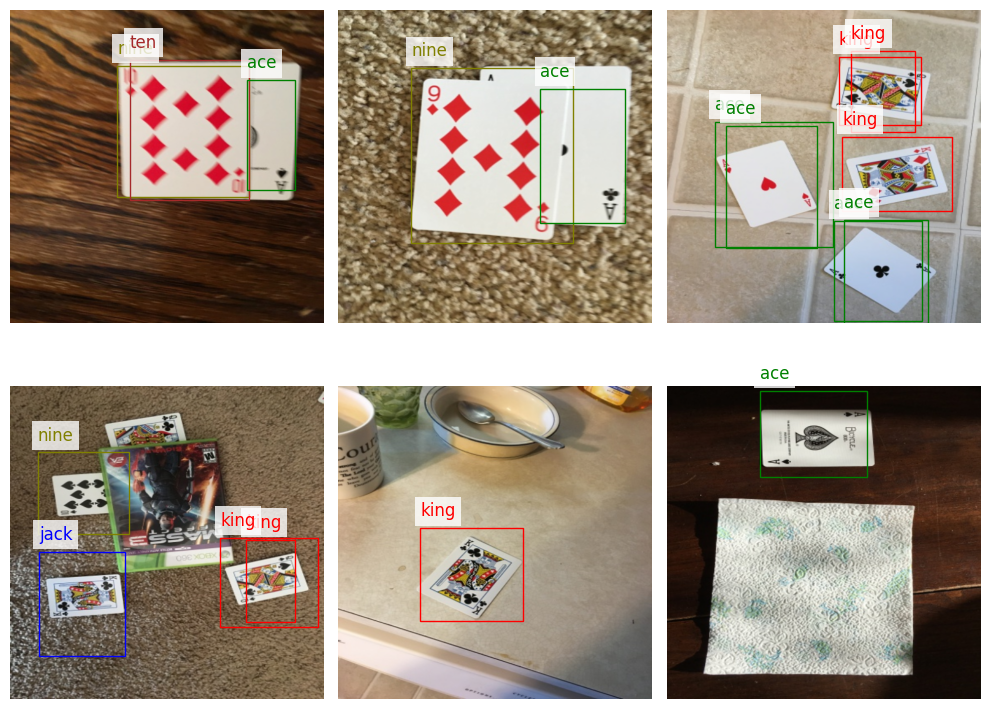

In [ ]:
# для просмотра результатов отрисовки предсказаний на всей валидационной выборке,
# варьировать параметр index_draw (от 1 до 7) при фиксированном размере батча 6

test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn, shuffle=False)
res = iter(test_loader)

index_draw = 6

for i in range(index_draw):
  batch = next(res)
  if i + 1 == index_draw:
    model.eval()
    with torch.no_grad():
      predict = model(batch["image"].to(device)).to("cpu")

    decoded_predict = decode_prediction(predict, threshold=0.2)
    visualize([batch["image"][j] for j in range(batch["image"].shape[0])], decoded_predict)

Самый простой из вариантов улучшений - приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.).

[YOLO v1](https://arxiv.org/abs/1506.02640).

#### Обучение готовой архитектуры YOLO v8 от ultralytics

In [ ]:
# !pip install ultralytics

**Перекладывание данных в формат [yolov8](https://roboflow.com/formats/yolov8-pytorch-txt)**

* в .yaml - пути к папкам с картинками, количество классов и их названия
* папки train valid, в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализация функции, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8 (массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n).

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    yolov8boxes = []
    for box in bboxes:
      xmin, ymin, xmax, ymax, class_int = box

      xc = (xmax + xmin) / 2 / w_im
      yc = (ymax + ymin) / 2 / h_im

      b_width = (xmax - xmin) / w_im
      b_height = (ymax - ymin) / h_im

      string = " ".join([str(class_int), str(xc), str(yc), str(b_width), str(b_height)])
      yolov8boxes.append(string)

    return yolov8boxes

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc = len(train_ds.class_dict) # число классов
names = list(train_ds.class_dict.keys()) # имена классов, массив строк

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.yaml")
results = model.train(data="data.yaml", epochs=100, imgsz=512, device="cuda:0", pretrained=False)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 21.0MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 104MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 2017.49it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 7 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1326.60it/s]

val: WARNING ⚠️ /content/valid/images/cam_image12.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2196]
val: WARNING ⚠️ /content/valid/images/cam_image16.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0952]
val: WARNING ⚠️ /content/valid/images/cam_image21.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1574]
val: WARNING ⚠️ /content/valid/images/cam_image23.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0622]
val: WARNING ⚠️ /content/valid/images/cam_image37.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5013      1.5093]
val: WARNING ⚠️ /content/valid/images/cam_image38.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.7209      1.1534       1.713      1.1389]
val: WARNING ⚠️ /content/valid/images/cam_image6.jpg: ignoring corrupt image/label: non-normal

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.83G      3.186      4.594       4.38         21        512: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         30         52   0.000702     0.0915   0.000536   8.42e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         2G      3.136      4.231      4.119         18        512: 100%|██████████| 21/21 [00:04<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         30         52    0.00041     0.0545   0.000306    6.7e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.02G      3.048      3.851      3.856         31        512: 100%|██████████| 21/21 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         30         52   0.000317      0.036   0.000287   6.42e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.03G      2.925      3.531      3.569         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         30         52   0.000629      0.073   0.000626   0.000112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.03G      2.765      3.381      3.388         28        512: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         30         52      0.544      0.037     0.0376     0.0178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.02G      2.704      3.316      3.243         17        512: 100%|██████████| 21/21 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         30         52     0.0839      0.133      0.106     0.0503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.02G      2.569      3.053      3.076         24        512: 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         30         52      0.209      0.266      0.175     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.03G      2.391      2.967      2.928         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         30         52      0.264      0.228      0.232      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.03G      2.232       2.82      2.787         29        512: 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         52      0.301      0.548      0.297      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.02G      2.137      2.739      2.724         24        512: 100%|██████████| 21/21 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         30         52      0.531       0.22      0.222      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         2G      1.969      2.547       2.53         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         30         52      0.345      0.485      0.371      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.02G       1.84      2.532      2.452         18        512: 100%|██████████| 21/21 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         30         52      0.269      0.464      0.382      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.03G       1.79      2.387      2.348         22        512: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         30         52      0.398      0.542       0.41      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.04G      1.771      2.346      2.321         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         30         52      0.277      0.454       0.31      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.02G      1.624      2.201      2.195         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         30         52      0.399      0.606      0.477      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.02G      1.582      2.199      2.143         20        512: 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         30         52      0.391       0.64      0.469      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.01G      1.559      2.129      2.123         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         30         52      0.303       0.62      0.427       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.02G       1.46      2.052      2.055         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         52      0.447      0.695      0.511      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.02G      1.432      2.105      2.021         15        512: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         30         52      0.393      0.695      0.481      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.04G      1.388      1.926      1.954         18        512: 100%|██████████| 21/21 [00:04<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30         52      0.413      0.723      0.535      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.02G      1.381      1.901      1.936         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         30         52      0.396      0.601      0.475      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.02G        1.3      1.852      1.857         11        512: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         30         52       0.44      0.722      0.542      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.02G      1.293      1.833       1.85         29        512: 100%|██████████| 21/21 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         30         52      0.455      0.698      0.557      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.02G      1.334      1.877      1.898         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30         52      0.483       0.77      0.569      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.01G      1.276      1.817      1.818         23        512: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         30         52      0.411       0.76      0.574      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.02G      1.296      1.784      1.859         33        512: 100%|██████████| 21/21 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         30         52      0.442      0.724      0.571      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.02G       1.27      1.798      1.809         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         52      0.413      0.715      0.586      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.04G      1.179      1.693      1.724         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         30         52      0.448      0.852      0.603       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.01G       1.19      1.761      1.737         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         30         52       0.47       0.79      0.558      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.02G      1.217      1.694      1.749         20        512: 100%|██████████| 21/21 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         30         52      0.424      0.762       0.61      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.02G      1.152      1.634      1.695         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         30         52      0.478      0.871       0.64      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.02G       1.15      1.651      1.696         22        512: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30         52      0.464      0.808      0.648      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.99G      1.124      1.621      1.667         28        512: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30         52      0.487      0.711      0.559      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.02G      1.115      1.603      1.631         30        512: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         30         52      0.459      0.724      0.603      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.02G      1.056      1.546      1.577         21        512: 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         30         52      0.491      0.746       0.62      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.02G      1.016      1.528      1.587         25        512: 100%|██████████| 21/21 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         30         52      0.501      0.882      0.669      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.99G      1.021      1.514      1.565         16        512: 100%|██████████| 21/21 [00:06<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         30         52      0.479      0.917      0.708       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.02G      1.002      1.492      1.544         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         30         52      0.504      0.771      0.631      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.03G     0.9828      1.471      1.522         33        512: 100%|██████████| 21/21 [00:05<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         30         52        0.6       0.79      0.689      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.04G       1.03      1.497      1.553         19        512: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         30         52       0.52       0.79      0.692      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.01G     0.9824      1.453      1.529         22        512: 100%|██████████| 21/21 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         30         52      0.651       0.83      0.757      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.01G     0.9992      1.436      1.529         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30         52      0.663      0.744      0.722      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.02G     0.9498      1.418      1.494         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         30         52      0.745      0.714      0.788      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.05G     0.9346      1.382      1.472         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         52      0.469      0.874       0.73      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.01G     0.9411      1.413      1.496         27        512: 100%|██████████| 21/21 [00:05<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         30         52      0.586      0.702       0.67      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.02G     0.9576       1.43      1.514         12        512: 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         30         52      0.555      0.824      0.718      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.02G     0.9213      1.397      1.449         23        512: 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30         52       0.56      0.779      0.726      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.02G     0.9551      1.412      1.476         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         30         52      0.643      0.743      0.738       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         2G      0.892      1.346      1.444         27        512: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         30         52      0.546      0.874      0.766      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.02G     0.8963      1.328      1.445         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30         52       0.54      0.921      0.744      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.02G     0.9103      1.316      1.437         28        512: 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         30         52      0.651      0.832      0.802      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.01G     0.9272      1.329       1.46         27        512: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         30         52      0.667      0.846      0.805      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.01G     0.8716      1.272      1.398         15        512: 100%|██████████| 21/21 [00:05<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         30         52      0.655      0.813      0.779       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.02G     0.9191      1.314      1.454         18        512: 100%|██████████| 21/21 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         30         52      0.687       0.86      0.789      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.02G     0.8648      1.254      1.423         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         30         52      0.684      0.777      0.825       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.02G     0.8638        1.3      1.412         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         30         52      0.686      0.704      0.795      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.02G     0.8349      1.229      1.385         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         30         52      0.665      0.875       0.82      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.02G     0.8782      1.223      1.417         18        512: 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         30         52      0.669      0.871      0.789      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.02G     0.8391      1.245      1.379         28        512: 100%|██████████| 21/21 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         30         52      0.642      0.889      0.813      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.02G     0.8309      1.218      1.354         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         30         52      0.625      0.797      0.795      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.99G     0.8344      1.218      1.371         32        512: 100%|██████████| 21/21 [00:06<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         30         52      0.685      0.824       0.79      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.02G     0.8172      1.191      1.339         13        512: 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         30         52      0.712      0.881      0.866      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.02G      0.816      1.188      1.362         25        512: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         30         52      0.651      0.885       0.84      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.02G     0.8532       1.19      1.382         28        512: 100%|██████████| 21/21 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         30         52      0.734      0.911      0.863      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.03G     0.8241      1.205      1.357         20        512: 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         30         52      0.676      0.893      0.833      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.02G     0.8244      1.199      1.373         27        512: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         30         52       0.85      0.761       0.85      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.02G     0.8578       1.25      1.398         12        512: 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         30         52      0.769      0.812      0.837      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.01G     0.8013      1.179      1.334         20        512: 100%|██████████| 21/21 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         30         52       0.73      0.842      0.906       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.01G      0.792      1.165      1.332         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30         52      0.631       0.88       0.86      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.02G     0.8003      1.134      1.337         14        512: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         30         52      0.761      0.765      0.874      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.02G     0.8032      1.148      1.332         21        512: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         30         52      0.732       0.83      0.888      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.02G     0.7895      1.128      1.312         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         30         52      0.821      0.816      0.901      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.03G     0.7949      1.154      1.323         16        512: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30         52      0.712      0.807      0.856      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.02G     0.7674      1.091      1.309         28        512: 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         30         52       0.78      0.878      0.889      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.02G      0.734      1.055      1.283         16        512: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         30         52      0.715      0.872      0.846      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.01G     0.7489      1.077      1.286         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30         52      0.727       0.77      0.805      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.01G     0.7539      1.074      1.303         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         30         52      0.736       0.81      0.854      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.04G     0.7483      1.067       1.29         22        512: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         30         52      0.757      0.838      0.878       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.02G     0.7291      1.044      1.297         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         30         52      0.691      0.811      0.838      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.01G     0.7573      1.054       1.31         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         30         52      0.764      0.891       0.92       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.01G     0.7526      1.036      1.298         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         30         52      0.709       0.89      0.886       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.02G     0.7112      1.024      1.253         33        512: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         30         52      0.829       0.83      0.915      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.02G     0.7526      1.027      1.282         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         30         52      0.869      0.828       0.92      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.02G     0.7249      1.037      1.278         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         30         52       0.83      0.781      0.881      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.03G     0.7394       1.04      1.295         28        512: 100%|██████████| 21/21 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         30         52      0.724      0.846      0.873      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.02G     0.7158     0.9841      1.288         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         30         52      0.933      0.783      0.922      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.04G     0.6919     0.9595      1.249         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         52      0.949      0.796      0.937      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.02G     0.7043     0.9742      1.245         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         30         52      0.919      0.803      0.928      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.04G     0.6715     0.9623      1.238         17        512: 100%|██████████| 21/21 [00:04<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         30         52      0.871      0.877       0.95      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.02G     0.6865     0.9413      1.243         19        512: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         30         52      0.894      0.802      0.935      0.812


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.01G     0.6084     0.8657      1.185         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         30         52      0.801      0.886      0.936      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         2G     0.5801     0.8321       1.16         11        512: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         30         52      0.948      0.782      0.934      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.99G     0.5526     0.7992      1.124         12        512: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         30         52      0.871       0.72      0.885      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         2G     0.5605      0.796      1.133         11        512: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         30         52      0.897      0.841      0.922      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         2G     0.5494     0.7638      1.119         10        512: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         30         52      0.802      0.879      0.928      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         2G      0.535     0.7603      1.133         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         52      0.862      0.818       0.92      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.99G     0.5381     0.7401      1.115         14        512: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         30         52      0.942      0.836      0.936       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         2G     0.5172      0.704      1.101         10        512: 100%|██████████| 21/21 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         30         52      0.812        0.9      0.927      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         2G     0.5248      0.711      1.105          8        512: 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30         52      0.936      0.835      0.939      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.01G     0.5436     0.7043      1.121          8        512: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         30         52      0.952      0.809      0.934      0.813



100 epochs completed in 0.187 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


                   all         30         52      0.942      0.836      0.936      0.822
                  king         30          8        0.9      0.875      0.917      0.872
                  jack         30          6          1      0.625      0.863      0.687
                   ace         30         12      0.849      0.942      0.977      0.883
                   ten         30         11      0.975      0.909       0.96      0.836
                  nine         30          9      0.942          1      0.995        0.9
                 queen         30          6      0.984      0.667      0.903      0.755
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


**Отрисовка предсказаний на валидационной выборке**

In [ ]:
import random
from pathlib import Path

val_images = list(Path("./valid/images").glob("*.JPG"))
val_images = random.sample(val_images, k=9)

val_results = model(val_images, imgsz=512, conf=0.3, iou=0.45, device="cuda:0")


0: 512x384 1 ace, 1 nine, 1: 512x384 1 ten, 2: 512x384 1 nine, 3: 512x384 1 ace, 2 tens, 1 nine, 4: 512x384 1 ace, 5: 512x384 1 queen, 6: 512x384 1 ace, 1 nine, 7: 512x384 1 queen, 8: 512x384 1 king, 1 jack, 1 ace, 1 nine, 1 queen, 54.0ms
Speed: 1.4ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 384)


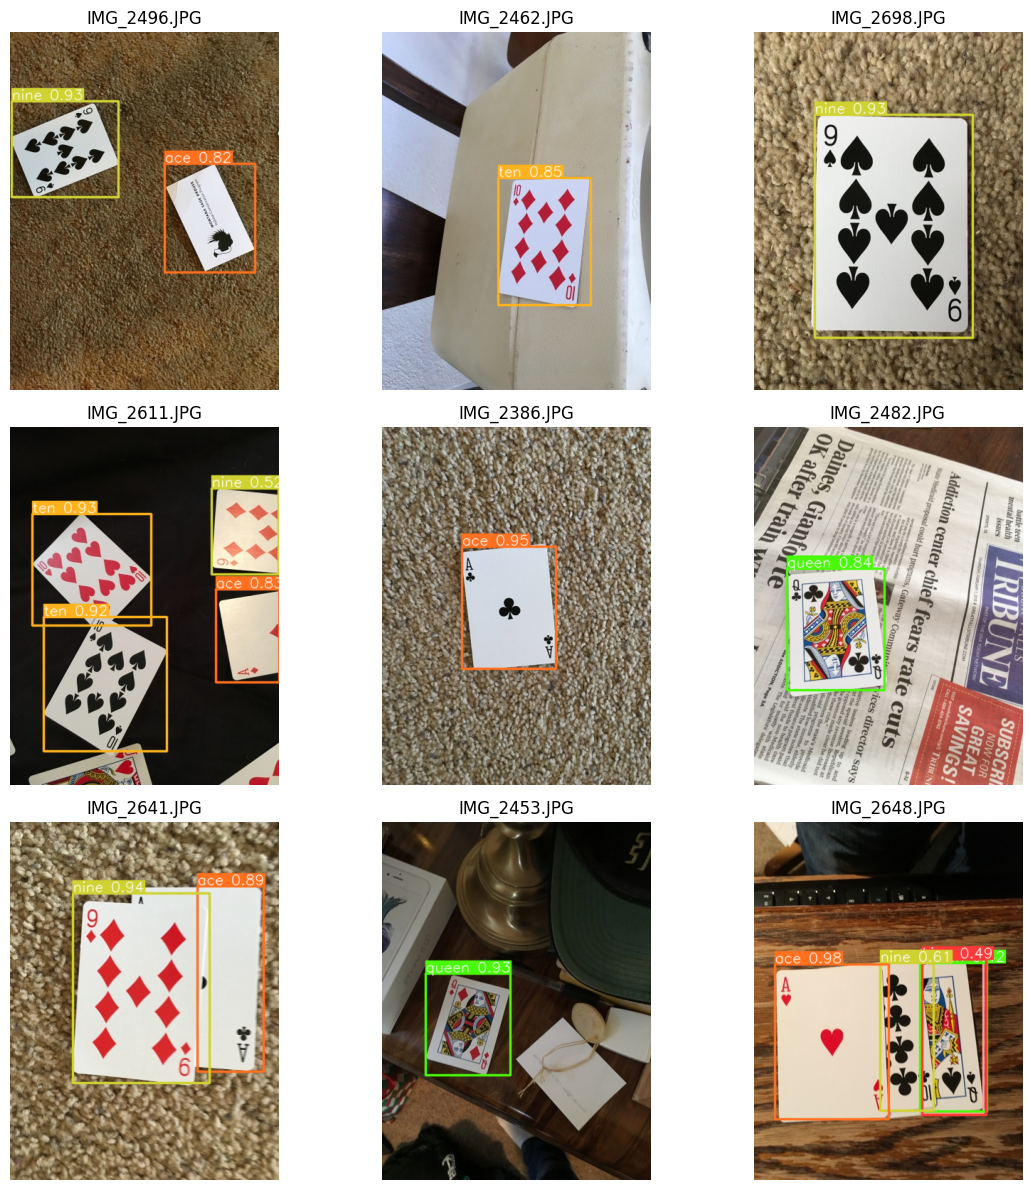

In [ ]:
fig, axes = plt.subplots(
    3, len(val_results) // 3 + len(val_results) % 3, figsize=(12, 12), dpi=100
)

for i, ax in enumerate(axes.reshape(-1)):

    ax.axis(False)

    if i >= len(val_results):
        break

    ax.imshow(val_results[i].plot()[:, :, ::-1])
    ax.set_title(Path(val_results[i].path).name)

fig.tight_layout()
plt.show()